<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_googleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과적합 이슈!!

## 정확도는 좋은데 검증 손실이 후반 부에 엄청 증가함!!

무엇을 시도해 볼까...
- 조기 종료
- 규제
- 학습률 스케일링

## 시도 1. EarlyStopping, Dropeout 적용
(11/04 01:33) 테스트 손실: 0.4447 테스트 정확도: 0.8935

- 결과 : 과적합 크게 개선, 정확도 안정적


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

Mounted at /content/drive


In [3]:
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


# 데이터 로드 (X_train, X_test가 정의되지 않은 경우를 대비)
if 'X_train' not in locals() or 'X_test' not in locals():
    TRAIN = "train/"
    TEST = "test/"
    DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

    INPUT_SIGNAL_TYPES = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",
        "total_acc_x_",
        "total_acc_y_",
        "total_acc_z_"
    ]

    def load_X(X_signals_paths):
        X_signals = []
        for signal_type_path in X_signals_paths:
            series_list = []
            with open(signal_type_path, 'r') as file:
                for row in file:
                    row_clean = row.replace('  ', ' ')
                    row_clean = row_clean.strip()
                    serie = row_clean.split(' ')
                    serie_array = np.array(serie, dtype=np.float32)
                    series_list.append(serie_array)
            X_signals.append(series_list)
        X_signals = np.array(X_signals)
        return np.transpose(X_signals, (1, 2, 0))

    X_train_signals_paths = [
        DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
        for signal in INPUT_SIGNAL_TYPES
    ]
    X_test_signals_paths = [
        DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
        for signal in INPUT_SIGNAL_TYPES
    ]

    X_train = load_X(X_train_signals_paths)
    X_test = load_X(X_test_signals_paths)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)


input_shape = (X_train.shape[1], X_train.shape[2])  # (시간 스텝, 특성 수)
num_classes = 6  # 6가지 활동 분류

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)


In [4]:


#===데이터 전체 저장===
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # ===형태 변환===
    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [5]:

# load_y
#텍스트 파일 읽기, 라벨 파싱, 인덱스 조정

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return np.array(labels, dtype=np.int32) - 1

In [6]:
# Define paths for the training and testing label files
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

# Load the data
y_train = load_y(y_train_path)  # 훈련 데이터 레이블
y_test = load_y(y_test_path)    # 테스트 데이터 레이블

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("첫 번째 훈련 데이터 레이블:", y_train[0])
print("첫 번째 테스트 데이터 레이블:", y_test[0])

y_train shape: (7352,)
y_test shape: (2947,)
첫 번째 훈련 데이터 레이블: 4
첫 번째 테스트 데이터 레이블: 4


In [7]:
# GoogleNet 모델 정의
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 컨볼루션
    conv_1x1 = Conv1D(filters_1x1, 1, padding='same', activation='relu')(x)

    # 3x3 컨볼루션 (1x1로 차원 축소 후)
    conv_3x3 = Conv1D(filters_3x3_reduce, 1, padding='same', activation='relu')(x)
    conv_3x3 = Conv1D(filters_3x3, 3, padding='same', activation='relu')(conv_3x3)

    # 5x5 컨볼루션 (1x1로 차원 축소 후)
    conv_5x5 = Conv1D(filters_5x5_reduce, 1, padding='same', activation='relu')(x)
    conv_5x5 = Conv1D(filters_5x5, 5, padding='same', activation='relu')(conv_5x5)

    # 맥스 풀링 + 1x1 컨볼루션
    pool_proj = MaxPooling1D(3, strides=1, padding='same')(x)
    pool_proj = Conv1D(filters_pool_proj, 1, padding='same', activation='relu')(pool_proj)

    # 모든 결과를 연결
    output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

def build_googlenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # 초기 레이어들 (1D용으로 단순화)
    x = Conv1D(64, 7, strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    x = Conv1D(64, 1, padding='same', activation='relu')(x)
    x = Conv1D(192, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    # 인셉션 모듈들
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    # 최종 레이어들
    x = GlobalAveragePooling1D()(x)  # 전역 평균 풀링
    x = Dropout(0.4)(x)  # 드롭아웃으로 과적합 방지
    output_layer = Dense(num_classes, activation='softmax')(x)  # 분류 레이어

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# 모델 생성
googlenet_model = build_googlenet(input_shape, num_classes)

# 모델 컴파일
googlenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 콜백 함수들 정의
early_stopping = EarlyStopping(
    monitor='val_loss',           # 검증 손실 모니터링
    patience=3,                   # 3 에포크 동안 개선되지 않으면 학습 중단
    restore_best_weights=True     # 최고 성능 가중치로 복원
)

model_checkpoint = ModelCheckpoint(
    'best_googlenet_model.h5',    # 저장할 파일명
    save_best_only=True,          # 최고 성능 모델만 저장
    monitor='val_loss'            # 검증 손실 기준으로 판단
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # 검증 손실 모니터링
    factor=0.5,                   # 학습률을 절반으로 감소
    patience=5,                   # 5 에포크 동안 개선되지 않으면 학습률 감소
    min_lr=0.0001                 # 최소 학습률
)

# 모델 학습
history = googlenet_model.fit(
    X_train,                      # 훈련 데이터
    y_train,                      # 훈련 라벨
    epochs=50,                    # 최대 에포크 수
    batch_size=64,                # 배치 크기
    validation_split=0.2,         # 검증 데이터 비율 (20%)
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # 콜백 함수들 적용
)

# 모델 요약 출력
googlenet_model.summary()

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4471 - loss: 1.1249

92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 295ms/step - accuracy: 0.4484 - loss: 1.1217 - val_accuracy: 0.7525 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.7080 - loss: 0.5438 - val_accuracy: 0.7090 - val_loss: 0.6053 - learning_rate: 0.0010
Epoch 3/50
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7697 - loss: 0.3970

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7719 - loss: 0.3937 - val_accuracy: 0.8831 - val_loss: 0.4296 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9182 - loss: 0.2592 - val_accuracy: 0.8878 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 5/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9490 - loss: 0.1415

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9490 - loss: 0.1422 - val_accuracy: 0.8824 - val_loss: 0.3253 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9451 - loss: 0.1715 - val_accuracy: 0.8973 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9600 - loss: 0.1036 - val_accuracy: 0.9007 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9620 - loss: 0.0946 - val_accuracy: 0.8960 - val_loss: 0.4177 - learning_rate: 0.0010


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 64)    │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 32, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 32, 64)    │      4,160 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 32, 192)   │     37,056 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 16, 192)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 16, 96)    │     18,528 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 16, 16)    │      3,088 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 16, 192)   │          0 │ max_pooling1d_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 16, 64)    │     12,352 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 16, 128)   │     36,992 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 16, 32)    │      2,592 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 16, 32)    │      6,176 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 256)   │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 16, 128)   │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 16, 32)    │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 16, 256)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 16, 128)   │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 16, 192)   │     73,920 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 16, 96)    │     15,456 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 16, 64)    │     16,448 │ max_pooling1d_3[

 Total params: 10,292,132 (39.26 MB)

 Trainable params: 3,430,710 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,861,422 (26.17 MB)

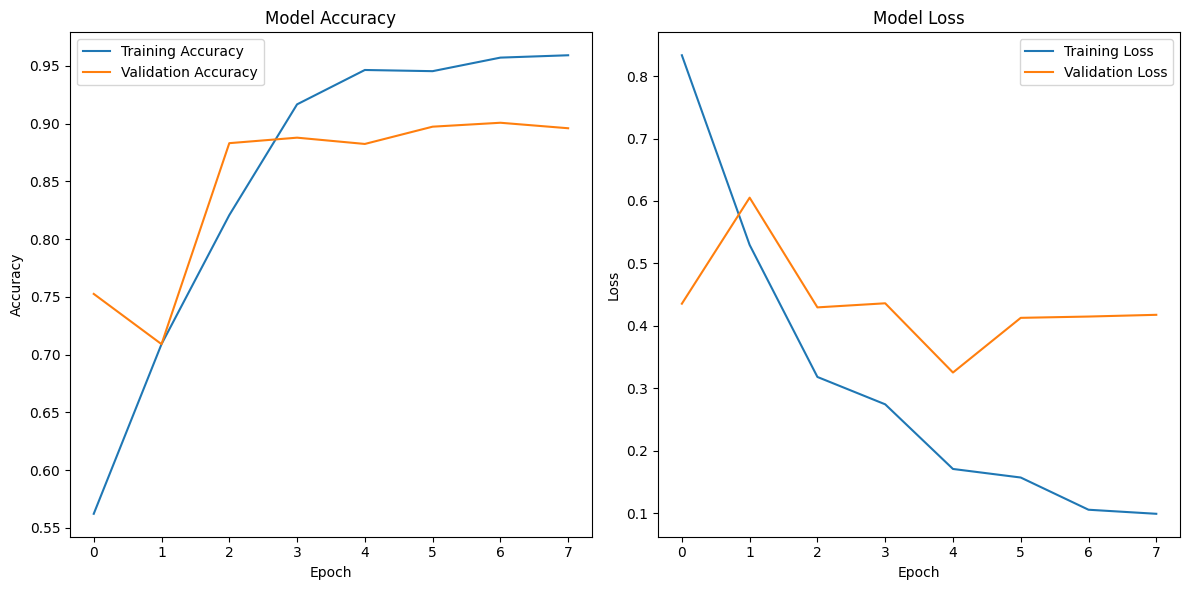

In [8]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 테스트 셋에서 모델 평가
print("\n테스트 셋에서 모델을 평가합니다...")
loss, accuracy = googlenet_model.evaluate(X_test, y_test)
print(f"테스트 손실: {loss:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")


테스트 셋에서 모델을 평가합니다...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8648 - loss: 0.4771
테스트 손실: 0.4447
테스트 정확도: 0.8935
